# GPT-2 Fine-Tuning Tutorial using raw text corpus

From Rey Farhan (https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)




Jena Jordahl
Other people consulted

Ran the first past of the pride and prejudice model on colab and then was unable to get a GPU to continue training on my own dataset.  Therefore, I switched to my own mac and processed on the CPU because I received errors when running pytorch using the GPU on the mac.

This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data. 

---------
Your task is to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting. 


# Setup

In [1]:
!pip install transformers
!pip install -U spacy
!pip install torch

You should consider upgrading via the '/Users/mwh/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/mwh/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/mwh/PycharmProjects/pythonProject/venv/bin/python -m pip install --upgrade pip' command.


In [2]:

%cd ./data

/Users/mwh/PycharmProjects/pythonProject/data


In [3]:
import os
import time
import datetime
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import random
random.seed(12)
import spacy
from tqdm import tqdm

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')

# !python -m spacy download en_core_web_lg


[nltk_data] Downloading package punkt to /Users/mwh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# !PYTORCH_ENABLE_MPS_FALLBACK=1

In [5]:
# If there's a GPU available...
# if torch.backends.mps.is_available():
#     print(torch.backends.mps.is_built())
#     dtype = torch.float
#     device = torch.device("mps")



    # net.to(device)
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
# !nvidia-smi

In [11]:
def read_docs(story,idx,df_item=None):

    if df_item:
        f=open(story[idx], encoding='utf-8')
        lines=f.read().strip().split('\n' ) #.readlines()
        doc=[line for line in lines]
    else:
        lines = pd.read_csv(story[idx],sep=',',header=0)
        doc=[b.strip() for b in lines.Sentence.values]
    print(doc[:5])
    return doc


def density_plot(docs):
    doc_lengths = []

    for doc in docs:

        # get rough token count distribution
        tokens = nltk.word_tokenize(doc)

        doc_lengths.append(len(tokens))

    doc_lengths = np.array(doc_lengths)

    sns.distplot(doc_lengths)
    return doc_lengths


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [12]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")


      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [13]:
def preprocess(textList, batchsz=500):
    # Input: text separated by new lines
    # Output: sentences with space around punctuation

    # sub-task 1: segment all the sentences in the wiki texts.
    # sub-task 2: tokenize the sentences from sub-task 2.
    # sub-task 3: lower-case the tokens from sub-task 3/4.

    nlp = spacy.load('en_core_web_lg')
    docDict = {}
    docList = []
    dropped = []
    cnt = 0

    for doc in tqdm(nlp.pipe(textList, batch_size=batchsz)): # Step 1
        # if doc.has_annotation("DEP"):
        # for ent in doc.ents:
            #  THIS LINE GIVES THE NAMED ENTITIES IN DOC
            # print(ent.text, ent.start_char, ent.end_char, ent.label_)
        docString = ''
        for spanText in doc.sents:
            spanT = spanText.text.strip()
            if len(spanT) < 8:
                dropped.append(spanT)
                continue
            if spanT:
                for tok in spanText:
                    docString += tok.text.strip().lower() + ' ' # Step 2 & 3
                docDict[cnt]= docString
                docList.append(docString)
                cnt += 1
    return  docDict, docList, dropped

# Create Training Set


In [23]:
# files = filename=['/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/prideAndPrejudice.txt']
files = filename=['./prideAndPrejudice.txt']
files[0]

'./prideAndPrejudice.txt'

In [15]:
docs= read_docs(files,0,True)
print(len(docs))


['It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.', 'However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.', '"My dear Mr. Bennet," said his lady to him one day, "have you heard that Netherfield Park is let at last?"', 'Mr. Bennet replied that he had not.', '"But it is," returned she; "for Mrs. Long has just been here, and she told me all about it."']
2063


We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/var/folders/r3/znh92ysd4vbgxhnfwfl_c0lr0000gn/T/ipykernel_10440/3897218905.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


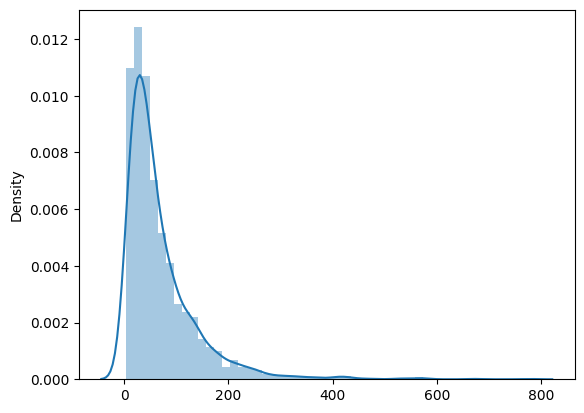

In [27]:
doc_lengths = density_plot(docs)

In [28]:
# the max token length
print(len(doc_lengths[doc_lengths > 768])/len(doc_lengths))

0.0004847309743092584


In [29]:
np.average(doc_lengths)

69.48763936015511

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most lines will be fit under the 768 embedding size limit for the small GPT2 model.

In [30]:
# The example output shows the data broken down by sentences not new line breaks.
# Therefore, I modified the preprocessing module from other assignments to break
# the input data into sentences.
sentDict, sent_list, dropped = preprocess(docs)
docs = sent_list
print(f" \nline size: {len(sentDict)}")
print(sent_list[0:2])

2063it [00:15, 133.40it/s]

 
line size: 6005
['it is a truth universally acknowledged , that a single man in possession of a good fortune , must be in want of a wife . ', 'however little known the feelings or views of such a man may be on his first entering a neighbourhood , this truth is so well fixed in the minds of the surrounding families , that he is considered the rightful property of some one or other of their daughters . ']


# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [31]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token = '<|pad|>')
#gpt2-medium


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [33]:
batch_size = 2
































































































































































































































































































































































































































































































































































































































































































































































I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each line in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the line is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the line is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [186]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,404 training samples
  601 validation samples


In [187]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [188]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False, pad_token_id=tokenizer.pad_token_id )

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [189]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [190]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [191]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [193]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                          #  token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of  2,702. Loss: 0.2627270519733429.   Elapsed: 0:00:49.
0:  bipartisan" i have heard what he said he would not believe in his feelings " but as a person, " but her fear of being seen as no more than ten more than ten years after being afraid of being seen.. " she was not afraid of being seen as it appeared as a ten times longer, and it could have been resolved.
 information, and. he, she. had not replied to any such letter, he was not the same to the last letter in that opinion of his opinion. 
  Batch   200  of  2,702. Loss: 0.3054927885532379.   Elapsed: 0:01:39.
0:  increasing which we ought to call. 
  Batch   300  of  2,702. Loss: 1.0877103805541992.   Elapsed: 0:02:30.
0: daythe day was over, and it seemed as if the morning had arrived on, for all. my brother, my cousin, did not appear to be in any ill humour. 
  Batch   400  of  2,702. Loss: 0.2223687469959259.   Elapsed: 0:03:20.
0:  Hangit was only a short walk, it had

This experiment was run using SPACEY to segment the text into sentences before sending it into GPT2 tokenizer and Model.

In [194]:
# MINE Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.35,0.18,0:22:54,0:00:48
2,0.16,0.12,0:22:53,0:00:48
3,0.09,0.09,0:22:58,0:00:48
4,0.05,0.09,0:23:08,0:00:48
5,0.03,0.09,0:23:04,0:00:48


Let's view the summary of the training process.

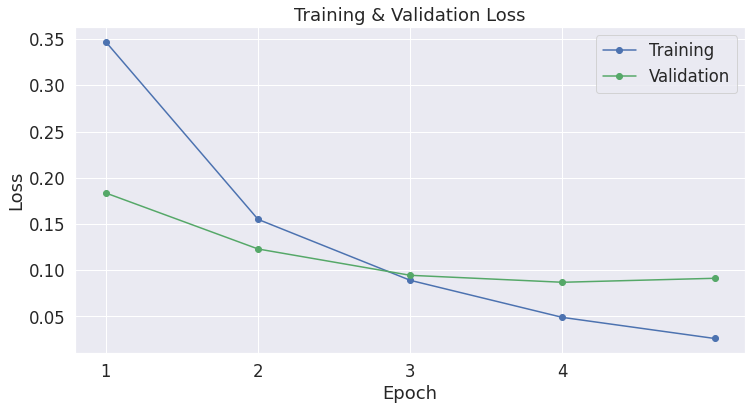

In [196]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### By using sentences I got a much better model.

### This experiment was run using newlines to segment the text before sending it into GPT2 tokenizer and Model.

In [114]:
# MINE Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.56,0.33,0:07:59,0:00:16
2,0.30,0.33,0:07:51,0:00:16
3,0.26,0.33,0:07:52,0:00:17
4,0.22,0.35,0:07:49,0:00:16
5,0.17,0.38,0:07:48,0:00:16


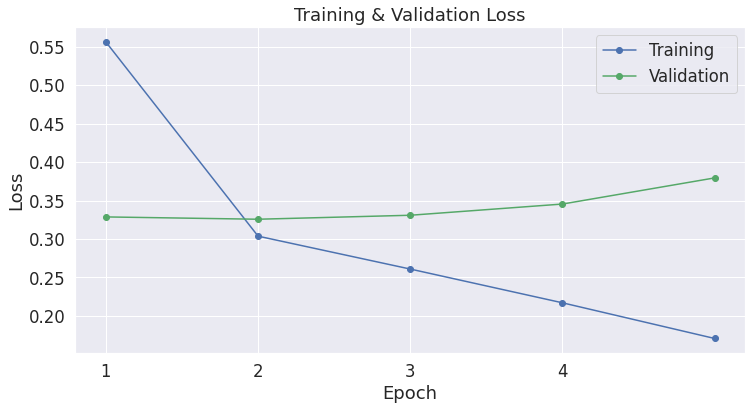

In [153]:
# Example
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [151]:
df_stats2 = pd.DataFrame([[1,	0.51,	0.32,	'0:08:38', '0:00:19'],
      [2,	0.30,	0.32,	'0:08:32', '0:00:19'],    
      [3,	0.25,	0.33,	'0:08:32', '0:00:19'],   
      [4,	0.20,	0.35,	'0:08:26', '0:00:19'],    
      [5,	0.15,	0.39,	'0:08:28',' 0:00:19']] , 
      columns=['epoch','Training Loss', 'Valid. Loss', 'Training Time', 'Validation Time'])

df_stats2 = df_stats2.set_index('epoch')
df_stats2

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.51,0.32,0:08:38,0:00:19
2,0.30,0.32,0:08:32,0:00:19
3,0.25,0.33,0:08:32,0:00:19
4,0.20,0.35,0:08:26,0:00:19
5,0.15,0.39,0:08:28,0:00:19


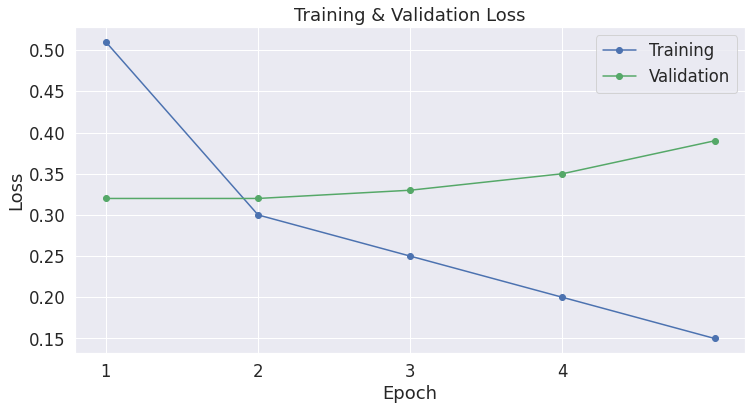

In [152]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats2['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats2['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [197]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [198]:
!cd '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/'

In [199]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Copy the model files to a directory in your Google Drive.
print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/


('/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/sent_model_save/added_tokens.json')

In [200]:
!ls -l --block-size=K ./sent_model_save/

total 499868K
-rw------- 1 root root      1K Dec 28 05:48 added_tokens.json
-rw------- 1 root root      1K Dec 28 05:48 config.json
-rw------- 1 root root    446K Dec 28 05:48 merges.txt
-rw------- 1 root root 498442K Dec 28 05:48 pytorch_model.bin
-rw------- 1 root root      1K Dec 28 05:48 special_tokens_map.json
-rw------- 1 root root      1K Dec 28 05:48 tokenizer_config.json
-rw------- 1 root root    976K Dec 28 05:48 vocab.json


In [201]:
!ls -l --block-size=M /content/drive/My\ Drive/Colab\ Notebooks/CS_505_PA7/sent_model_save/pytorch_model.bin

-rw------- 1 root root 487M Dec 28 05:48 '/content/drive/My Drive/Colab Notebooks/CS_505_PA7/sent_model_save/pytorch_model.bin'


In [202]:
# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# Generate Text

### Sentence trained version

In [203]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[50257]], device='cuda:0')
0: " yes, very agreeable. " 


1: " yes, sir. " 


2: " i have written to colonel forster to desire him to find out, if possible, from some of the young man's intimates in the regiment, whether wickham has any relations or connections who would be likely to know in what part of town he has now concealed himself. if there were anyone that one could apply to with a probability of gaining such a clue as that, it might be of essential consequence. at present we have nothing to guide us. colonel forster will, i dare say, do everything in his power to satisfy us on this head. 




### Newline break out of text

In [163]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[50257]], device='cuda:0')
0: Jane soon had enough to say in her answer.


1: Elizabeth assured her with real sorrow that she was. "I could not bear to think her mother's ill; but there were two or three tears in the room upstairs."


2: Mr. Bennet, though disconcerted by her approach, and unwilling to give her a formal answer, said very stiffly:




These aren't bad at all! Now train the model on your chosen raw text that is roughly comparable in size to pride and prejudice. 

(5 pts) Draw a figure for tracking train and validation losses. 

(5 pts) Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?


> YOUR ANSWER HERE  -

## MY ANSWER

Using the Game of Thrones script, I selected a small section of the first episodes which was about the same size as pride and prejudice.

In [16]:
# files = filename=['/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/prideAndPrejudice.txt',
#                   '/content/drive/MyDrive/Colab Notebooks/CS_505_PA7/Game_of_Thrones_Script_new.csv'
files = filename=['./prideAndPrejudice.txt',
                  './Game_of_Thrones_Script_new.csv'
                  ]
files[1]

# docs= read_docs(files,0,True)
got_docs= read_docs(files,1,False)
got_docs= got_docs[:len(docs)]

len(got_docs)

['It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.', 'However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.', '"My dear Mr. Bennet," said his lady to him one day, "have you heard that Netherfield Park is let at last?"', 'Mr. Bennet replied that he had not.', '"But it is," returned she; "for Mrs. Long has just been here, and she told me all about it."']
["What do you expect? They're savages. One lot steals a goat from another lot and before you know it, they're ripping each other to pieces.", "I've never seen wildlings do a thing like this. I've never seen a thing like this, not ever in my life.", 'How close did you get?', 'Close as any man would.', 'We should head back to the wall.']


2063

/var/folders/r3/znh92ysd4vbgxhnfwfl_c0lr0000gn/T/ipykernel_12356/3412140581.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


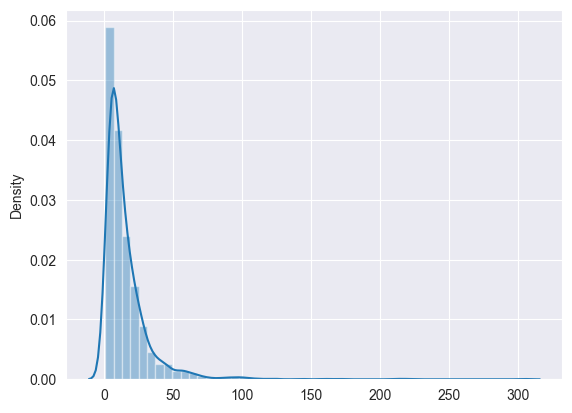

In [17]:

got_doc_lengths = density_plot(got_docs)
# getty_doc_lengths = density_plot(getty_docs)

In [18]:
print(f'Max token length greater than 768: {len(got_doc_lengths[got_doc_lengths > 768])/len(got_doc_lengths)}, \naverage length of sentence: {np.average(got_doc_lengths)}')

Max token length greater than 768: 0.0, 
average length of sentence: 15.652932622394571


In [19]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [21]:
# Create new data loaders
batch_size = 2

dataset = GPT2Dataset(got_docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [22]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False, pad_token_id=tokenizer.pad_token_id )

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# device = torch.device("cuda")
# model.cuda()
model #.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [24]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

/Users/mwh/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
total_t0 = time.time()

training_stats = []

model = model #.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0] #.to(device)
        b_labels = batch[0] #.to(device)
        b_masks = batch[1]  #.to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0] #.to(device)
        b_labels = batch[0] #.to(device)
        b_masks = batch[1] #.to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                          #  token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of    928. Loss: 0.045271921902894974.   Elapsed: 0:05:02.
0:  bipartisanThe law of it will make all of the people, at the law of your husband. I know that I am talking about one thing.
  Batch   200  of    928. Loss: 0.07716172933578491.   Elapsed: 0:10:03.
0:  increasingThe title of this council is me, my father is going to have a family... A boy! You're a family.
  Batch   300  of    928. Loss: 0.08584555238485336.   Elapsed: 0:15:03.
0: dayAye.
  Batch   400  of    928. Loss: 0.6756883263587952.   Elapsed: 0:20:03.
0:  HangYou're doing great work, Ben.
  Batch   500  of    928. Loss: 0.2853453755378723.   Elapsed: 0:25:04.
0:  foodsArya.
  Batch   600  of    928. Loss: 0.1586478352546692.   Elapsed: 0:30:04.
0:  trailIf you're with the Kings - and what is the meaning of the last line?
  Batch   700  of    928. Loss: 0.11679034680128098.   Elapsed: 0:35:04.
0: intendAnd I know not.
  Batch   800  of    928. Loss: 0.0815797820

### (5 pts) Draw a figure for tracking train and validation losses.



In [34]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
# df_stats = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.17,0.07,0:46:28,0:01:21
2,0.07,0.08,0:46:15,0:01:21
3,0.06,0.08,0:46:11,0:01:21
4,0.04,0.09,0:46:26,0:01:20
5,0.03,0.10,0:45:47,0:01:20


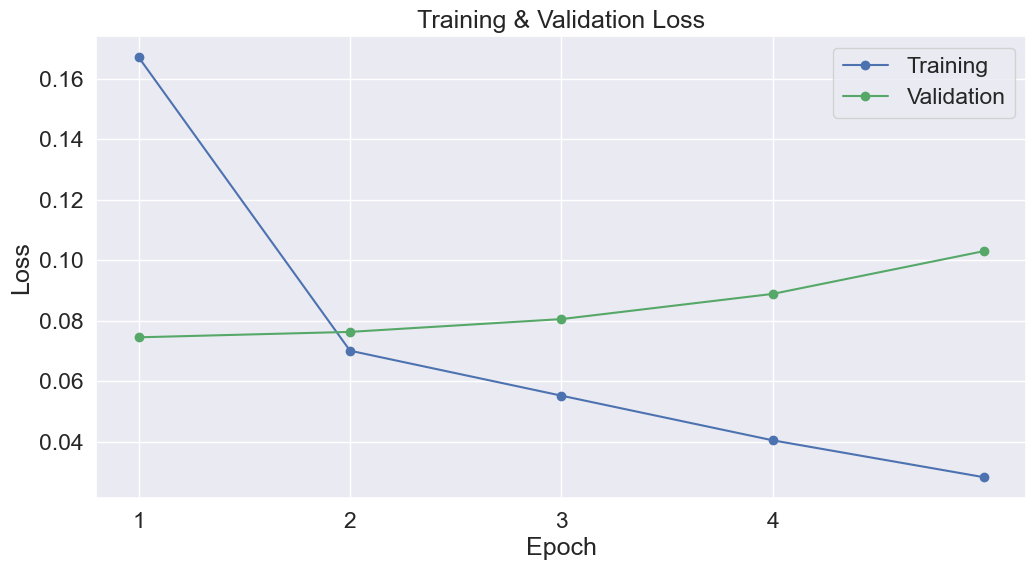

In [35]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### (5 pts) Print out some sample text from your chosen data and report 10 example generations that you think are interesting! Do your examples look like your training text?

In [33]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated #.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

tensor([[50257]])
0: I'm not a boy.


1: But you couldn't kill him. You just stood there and watched.


2: What did I buy you for?




In [37]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './got_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Copy the model files to a directory in your Google Drive.
print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./got_model_save/


('./got_model_save/tokenizer_config.json',
 './got_model_save/special_tokens_map.json',
 './got_model_save/vocab.json',
 './got_model_save/merges.txt',
 './got_model_save/added_tokens.json')

In [ ]:
# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))